In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import os 
import json
import analysis

output_dir = './output'

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


In [2]:
output_filenames = [i for i in os.listdir(output_dir) if i.endswith('json')]
len(output_filenames)

850

In [3]:
def read_json(fn):
    with open(os.path.join(output_dir, fn)) as f: 
        data = json.load(f)
    return data


In [4]:
# import re 
# for fn in output_filenames: 
#     fn2 = fn 
#     # if 'preprocessed' in fn2: 
#     #     fn2 = fn2.replace('preprocessed', 'pca+knn10')
#     # if '_knn' in fn2: 
#     #     fn2 = fn2.replace('_knn', '_knn50')
#     if '__' in fn2: 
#         fn2 = fn2.replace('__', '_')
#     # if re.search(r'00[0,1]_GCN_[0-9\.]+_*', fn2): 
#     #     tmp = fn2.split('_')
#     #     tmp.insert(1, '685genes')
#     #     fn2 = '_'.join(tmp)
#     #     os.system(f'cp {os.path.join(output_dir, fn)} {os.path.join(output_dir, fn2)}')
#     if fn2 != fn: 
#         print(fn2)
#         os.system(f'git mv {os.path.join(output_dir, fn)} {os.path.join(output_dir, fn2)}')

In [5]:
output_filenames = [
    fn 
    for fn in output_filenames
    # if not 'DGN' in fn and not 'DynEdge' in fn and not 'genes' in fn # normal models
    # if '_DGN.' in fn  # DGN models
    # if '_DynEdge.' in fn  
    # if '_DynEdgeDGN.' in fn  
    if 'genes' in fn 
]
len(output_filenames)

168

In [6]:
output_configs = []
for fn in output_filenames: 
    output_configs.append([i for i in os.path.splitext(fn)[0].split('_') if i])  # runid, model_type, model_params, edge_index_type


In [7]:
if len(output_configs[0]) == 4: 
    cols = ['runid', 'model_type', 'model_params', 'edge_index_type']
    hasngenes = False
else: 
    cols = ['runid', 'genes', 'model_type', 'model_params', 'edge_index_type']
    hasngenes = True
output_configs = pd.DataFrame(output_configs, columns=cols)
output_configs['filename'] = output_filenames
output_configs.head()

,runid,genes,model_type,model_params,edge_index_type,filename
0,000,100genes,GCN,1.64,empty,000_100genes_GCN_1.64_empty.json
1,000,100genes,GCN,1.64,euc0.5,000_100genes_GCN_1.64_euc0.5.json
2,000,100genes,GCN,1.64,euc2,000_100genes_GCN_1.64_euc2.json
3,000,100genes,GCN,1.64,knn20,000_100genes_GCN_1.64_knn20.json
4,000,100genes,GCN,1.64,knn50,000_100genes_GCN_1.64_knn50.json


In [8]:
metrics = []
for row in output_configs.itertuples():
    fn = row.filename
    try:    
        data = read_json(fn)
    except: 
        print(row)
        raise 
    metrics.append([
        data['epochs'][-1], 
        data['train_accs'][-1], 
        max(data['train_accs']), 
        data['test_accs'][-1], 
        max(data['test_accs']), 
        data['time'], 
        data['nparams'], 
    ])
output_metrics = pd.concat([
    output_configs, pd.DataFrame(metrics, columns=['epochs', 'final_train_acc', 'max_train_acc', 'final_test_acc', 'max_test_acc', 'time', 'nparams'])
], axis=1)
output_metrics.head()

,runid,genes,model_type,model_params,edge_index_type,filename,epochs,final_train_acc,max_train_acc,final_test_acc,max_test_acc,time,nparams
0,000,100genes,GCN,1.64,empty,000_100genes_GCN_1.64_empty.json,2000,58.219898,58.219898,40.487805,42.926830,5.241043,2299
1,000,100genes,GCN,1.64,euc0.5,000_100genes_GCN_1.64_euc0.5.json,2000,63.036650,63.036650,42.926830,43.048781,5.940813,2299
2,000,100genes,GCN,1.64,euc2,000_100genes_GCN_1.64_euc2.json,2000,60.471207,60.471207,41.951218,42.317075,4.659422,2299
3,000,100genes,GCN,1.64,knn20,000_100genes_GCN_1.64_knn20.json,2000,57.329845,57.329845,41.829267,41.829267,6.157945,2299
4,000,100genes,GCN,1.64,knn50,000_100genes_GCN_1.64_knn50.json,2000,55.602098,55.602098,42.926830,43.170732,5.550849,2299


In [9]:
g = ['model_type', 'model_params', 'edge_index_type']
if hasngenes: 
    g.append('genes')
output_summary = output_metrics.groupby(g).agg(
    epochs=('epochs', 'max'), 
    mean_train_acc=('final_train_acc', 'mean'), 
    mean_test_acc=('final_test_acc', 'mean'), 
    max_test_acc=('final_test_acc', 'max'), 
    min_test_acc=('final_test_acc', 'min'), 
    mean_time=('time', 'mean'), 
    nparams=('nparams', 'mean'), 
    runs=('runid', 'count'), 
    filename=('filename', lambda x: x.iloc[0]), 
    # best_params=(['model_params', 'test_acc'], lambda x,y: x.iloc[np.argmax(y)])
)
output_summary.head(7) 

epochs  mean_train_acc  \
model_type model_params edge_index_type genes                              
GCN        1.64         empty           100genes    2000       58.821991   
                                        200genes    2000       63.952881   
                                        400genes    2000       71.910995   
                                        685genes    2000       84.109947   
                        euc0.5          100genes    2000       62.513089   
                                        200genes    2000       63.167539   
                                        400genes    2000       71.570683   

                                                  mean_test_acc  max_test_acc  \
model_type model_params edge_index_type genes                                   
GCN        1.64         empty           100genes      40.304878     40.487805   
                                        200genes      44.939025     46.219513   
                                        400genes      42.743902     46.829268   
                                        685genes      47.012195     50.731707   
                        euc0.5          100genes      41.890244     42.926830   
                                        200genes      44.695123     46.707317   
                                        400genes      40.914634     41.707316   

                                                  min_test_acc  mean_time  \
model_type model_params edge_index_type genes                               
GCN        1.64         empty           100genes     40.121952   5.372285   
                                        200genes     43.658537   4.612192   
                                        400genes     38.658535   4.841704   
                                        685genes     43.292683   3.880284   
                        euc0.5          100genes     40.853658   6.192216   
                                        200genes     42.682928   5.214599   
                                        400genes     40.121952   5.415324   

                                                  nparams  runs  \
model_type model_params edge_index_type genes                     
GCN        1.64         empty           100genes   2299.0     2   
                                        200genes   4199.0     2   
                                        400genes   7999.0     2   
                                        685genes  13414.0     2   
                        euc0.5          100genes   2299.0     2   
                                        200genes   4199.0     2   
                                        400genes   7999.0     2   

                                                                           filename  
model_type model_params edge_index_type genes                                        
GCN        1.64         empty           100genes   000_100genes_GCN_1.64_empty.json  
                                        200genes   000_200genes_GCN_1.64_empty.json  
                                        400genes   000_400genes_GCN_1.64_empty.json  
                                        685genes   000_685genes_GCN_1.64_empty.json  
                        euc0.5          100genes  000_100genes_GCN_1.64_euc0.5.json  
                                        200genes  000_200genes_GCN_1.64_euc0.5.json  
                                        400genes  000_400genes_GCN_1.64_euc0.5.json

In [10]:
output_best = output_summary.sort_values('mean_test_acc', ascending=False)
output_best.head(10)

epochs  mean_train_acc  \
model_type model_params edge_index_type genes                              
GCN        4.64         pca+knn30       685genes    2000       65.497383   
           2.64         pca+knn30       685genes    2000       80.104712   
           1.64         pca+knn30       685genes    2000       79.345551   
           2.64         pca+knn10       685genes    2000       83.115184   
           4.64         pca+knn10       685genes    2000       70.157069   
           2.64         pca+knn30       400genes    2000       67.984295   
           1.64         pca+knn10       685genes    2000       81.727749   
           4.64         pca+knn10       400genes    2000       61.151835   
                        pca+knn30       400genes    2000       58.612564   
           1.64         pca+knn30       400genes    2000       71.570683   

                                                  mean_test_acc  max_test_acc  \
model_type model_params edge_index_type genes                                   
GCN        4.64         pca+knn30       685genes      58.597562     59.756100   
           2.64         pca+knn30       685genes      58.231705     58.902436   
           1.64         pca+knn30       685genes      58.109754     58.170730   
           2.64         pca+knn10       685genes      57.012194     57.195121   
           4.64         pca+knn10       685genes      56.768292     58.414632   
           2.64         pca+knn30       400genes      55.304879     56.097561   
           1.64         pca+knn10       685genes      55.243903     55.731708   
           4.64         pca+knn10       400genes      54.878050     55.243903   
                        pca+knn30       400genes      52.682927     53.292686   
           1.64         pca+knn30       400genes      52.621949     52.682924   

                                                  min_test_acc  mean_time  \
model_type model_params edge_index_type genes                               
GCN        4.64         pca+knn30       685genes     57.439023  31.083091   
           2.64         pca+knn30       685genes     57.560974  10.344701   
           1.64         pca+knn30       685genes     58.048779   4.104219   
           2.64         pca+knn10       685genes     56.829268   8.668209   
           4.64         pca+knn10       685genes     55.121952  22.680625   
           2.64         pca+knn30       400genes     54.512197   9.798316   
           1.64         pca+knn10       685genes     54.756099   4.173247   
           4.64         pca+knn10       400genes     54.512197  15.142578   
                        pca+knn30       400genes     52.073169  19.486120   
           1.64         pca+knn30       400genes     52.560973   5.465013   

                                                  nparams  runs  \
model_type model_params edge_index_type genes                     
GCN        4.64         pca+knn30       685genes  57619.0     2   
           2.64         pca+knn30       685genes  49299.0     2   
           1.64         pca+knn30       685genes  13414.0     2   
           2.64         pca+knn10       685genes  49299.0     2   
           4.64         pca+knn10       685genes  57619.0     2   
           2.64         pca+knn30       400genes  31059.0     2   
           1.64         pca+knn10       685genes  13414.0     2   
           4.64         pca+knn10       400genes  39379.0     2   
                        pca+knn30       400genes  39379.0     2   
           1.64         pca+knn30       400genes   7999.0     2   

                                                                              filename  
model_type model_params edge_index_type genes                                           
GCN        4.64         pca+knn30       685genes  000_685genes_GCN_4.64_pca+knn30.json  
           2.64         pca+knn30       685genes  000_685genes_GCN_2.64_pca+knn30.json  
           1.64         pca+knn30       685genes  000_685genes_GCN_1.64_pca+kn

- pca+knn10 edges: 41566 edge density: 0.005577157884850192
- knn20 edges: 54600 edge density: 0.007326007326007326
- euc0.5 edges: 43700 edge density: 0.005863489379972896
- pca+knn30 edges: 129840 edge density: 0.017421406432395443
- knn50 edges: 136500 edge density: 0.018315018315018316
- euc2 edges: 133494 edge density: 0.017911685384212856

/tmp/ipykernel_1253/2622510389.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  fn = output_metrics.set_index(['model_type', 'model_params', 'edge_index_type']).loc[ind].sort_values('final_test_acc').iloc[0].filename


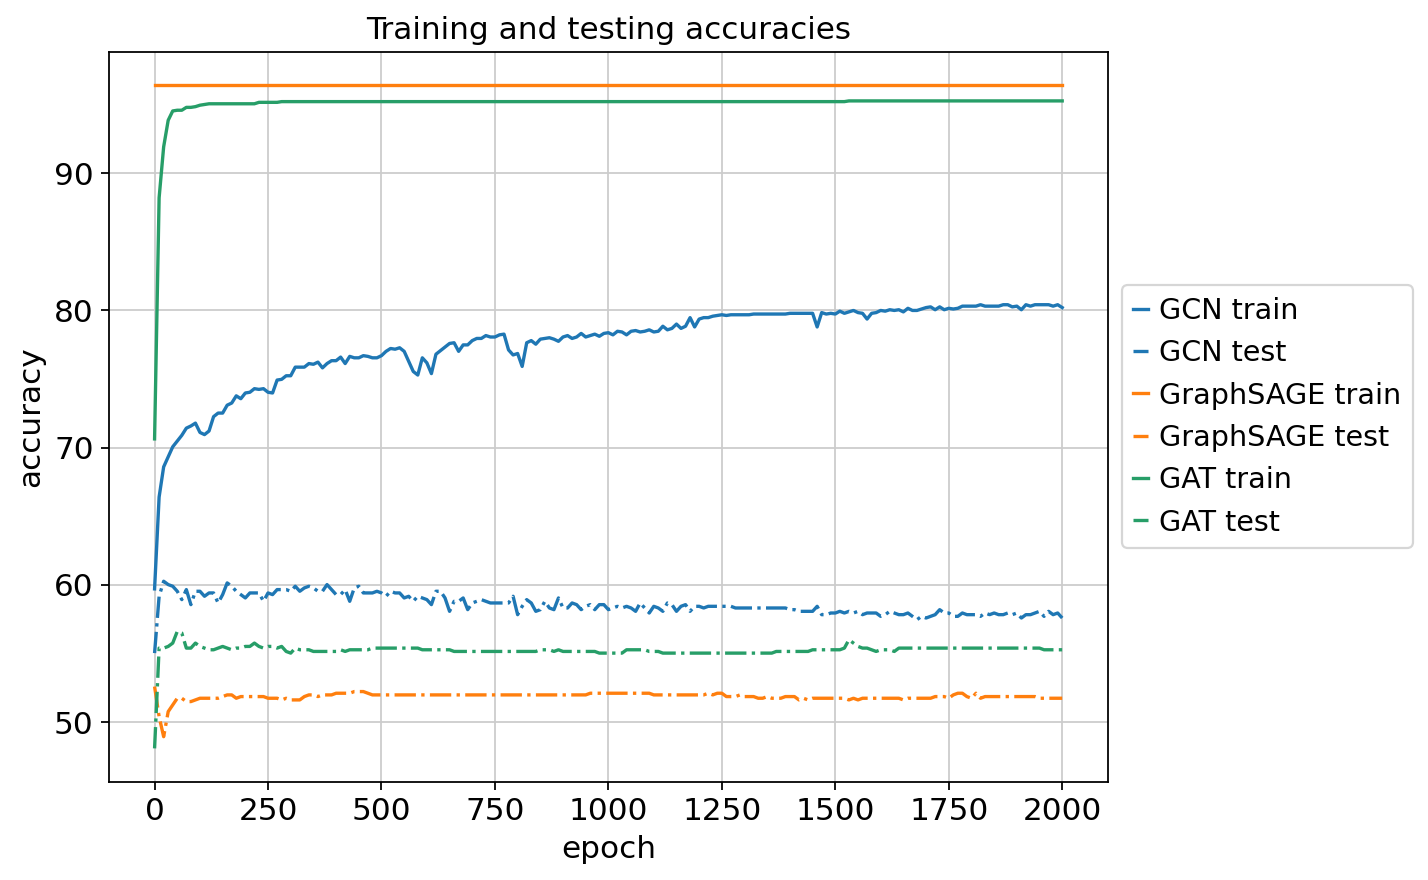

In [11]:
models_to_plot = [
    ('GCN', '2.64', 'pca+knn30'), 
    ('GraphSAGE', '2.64', 'pca+knn30'), 
    ('GAT', '1.64.32.False', 'pca+knn30'), 
]

fig, ax = plt.subplots(figsize=(8,6))
for ind in models_to_plot: 
    # fn = output_summary.loc[ind].filename
    fn = output_metrics.set_index(['model_type', 'model_params', 'edge_index_type']).loc[ind].sort_values('final_test_acc').iloc[0].filename
    metrics = read_json(fn)
    nm = ind[0]
    l = ax.plot(metrics['epochs'], metrics['train_accs'], label=f'{nm} train')
    ax.plot(metrics['epochs'], metrics['test_accs'], '-.', c = l[0].get_color(), label=f'{nm} test')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Training and testing accuracies')
ax.legend(bbox_to_anchor=(1.0, 0.7))
fig.savefig('./plots/ablation-training.png', bbox_inches="tight")

In [11]:
g = ['model_type', 'edge_index_type']
if hasngenes: 
    g.append('genes')
output_summary_bestparams = output_summary[output_summary.groupby(level=g).mean_test_acc.transform('max').eq(output_summary.mean_test_acc)]
output_summary_bestparams

epochs  mean_train_acc  \
model_type model_params edge_index_type genes                              
GCN        1.64         empty           200genes    2000       63.952881   
                        euc0.5          200genes    2000       63.167539   
                        euc2            200genes    2000       62.251312   
                        knn20           100genes    2000       56.570682   
                                        200genes    2000       54.424086   
                        knn50           100genes    2000       55.863875   
                                        200genes    2000       51.884818   
                        pca+knn10       200genes    2000       63.821989   
                        pca+knn30       200genes    2000       61.753926   
           2.64         empty           100genes    2000       55.759165   
                        euc2            100genes    2000       53.036651   
                        knn20           685genes    2000       70.130891   
                        pca+knn10       100genes    2000       52.329844   
                                        685genes    2000       83.115184   
                        pca+knn30       100genes    2000       52.958116   
                                        400genes    2000       67.984295   
           4.64         empty           400genes    2000       73.717278   
                                        685genes    2000       86.465970   
                        euc0.5          100genes    2000       51.361257   
                                        400genes    2000       60.130888   
                                        685genes    2000       75.575915   
                        euc2            400genes    2000       56.465968   
                                        685genes    2000       71.256545   
                        knn20           400genes    2000       60.811520   
                        knn50           400genes    2000       59.109950   
                                        685genes    2000       67.015707   
                        pca+knn10       400genes    2000       61.151835   
                        pca+knn30       685genes    2000       65.497383   

                                                  mean_test_acc  max_test_acc  \
model_type model_params edge_index_type genes                                   
GCN        1.64         empty           200genes      44.939025     46.219513   
                        euc0.5          200genes      44.695123     46.707317   
                        euc2            200genes      43.109757     43.292683   
                        knn20           100genes      41.463414     41.829267   
                                        200genes      38.414633     38.902438   
                        knn50           100genes      42.682928     42.926830   
                                        200genes      39.817072     40.853658   
                        pca+knn10       200genes      47.804877     48.048779   
                        pca+knn30       200genes      50.121951     50.975609   
           2.64         empty           100genes      45.426829     46.951219   
                        euc2            100genes      44.817072     45.243901   
                        knn20           685genes      38.536586     40.487805   
                        pca+knn10       100genes      46.402439     47.073171   
                                        685genes      57.012194     57.195121   
                        pca+knn30       100genes      46.463415     46.585366   
                                        400genes      55.304879     56.097561   
           4.64         empty           400genes      48.963416     49.024391   
                                        685genes      51.341462     51.585364   
                        euc0.5          100genes      45.121951     45.609757   
                                        400genes      43.963414     

In [14]:
# could heatmap the values - use excel and screenshot
output_summary_bestparams.reset_index().pivot(values='mean_test_acc', index='model_type', columns='edge_index_type')

ValueError: Index contains duplicate entries, cannot reshape

In [12]:
output_summary_bestmodel = output_summary[output_summary.groupby(level=['edge_index_type']).mean_test_acc.transform('max').eq(output_summary.mean_test_acc)]
output_summary_bestmodel

epochs  mean_train_acc  \
model_type model_params edge_index_type genes                              
GCN        1.64         knn20           100genes    2000       56.570682   
                        knn50           100genes    2000       55.863875   
           2.64         pca+knn10       685genes    2000       83.115184   
           4.64         empty           685genes    2000       86.465970   
                        euc0.5          685genes    2000       75.575915   
                        euc2            685genes    2000       71.256545   
                        pca+knn30       685genes    2000       65.497383   

                                                  mean_test_acc  max_test_acc  \
model_type model_params edge_index_type genes                                   
GCN        1.64         knn20           100genes      41.463414     41.829267   
                        knn50           100genes      42.682928     42.926830   
           2.64         pca+knn10       685genes      57.012194     57.195121   
           4.64         empty           685genes      51.341462     51.585364   
                        euc0.5          685genes      48.109756     48.536587   
                        euc2            685genes      46.097562     48.414636   
                        pca+knn30       685genes      58.597562     59.756100   

                                                  min_test_acc  mean_time  \
model_type model_params edge_index_type genes                               
GCN        1.64         knn20           100genes     41.097561   5.972768   
                        knn50           100genes     42.439026   5.534317   
           2.64         pca+knn10       685genes     56.829268   8.668209   
           4.64         empty           685genes     51.097560  19.274446   
                        euc0.5          685genes     47.682926  26.616947   
                        euc2            685genes     43.780488  45.831775   
                        pca+knn30       685genes     57.439023  31.083091   

                                                  nparams  runs  \
model_type model_params edge_index_type genes                     
GCN        1.64         knn20           100genes   2299.0     2   
                        knn50           100genes   2299.0     2   
           2.64         pca+knn10       685genes  49299.0     2   
           4.64         empty           685genes  57619.0     2   
                        euc0.5          685genes  57619.0     2   
                        euc2            685genes  57619.0     2   
                        pca+knn30       685genes  57619.0     2   

                                                                              filename  
model_type model_params edge_index_type genes                                           
GCN        1.64         knn20           100genes      000_100genes_GCN_1.64_knn20.json  
                        knn50           100genes      000_100genes_GCN_1.64_knn50.json  
           2.64         pca+knn10       685genes  000_685genes_GCN_2.64_pca+knn10.json  
           4.64         empty           685genes      000_685genes_GCN_4.64_empty.json  
                        euc0.5          685genes     000_685genes_GCN_4.64_euc0.5.json  
                        euc2            685genes       000_685genes_GCN_4.64_euc2.json  
                        pca+knn30       685genes  000_685genes_GCN_4.64_pca+knn30.json

/tmp/ipykernel_1253/3910699248.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([plt.Text(-1.0, 0, '-1')] + xtl + [plt.Text(-1.0, 0, str(len(xtl)))])
/tmp/ipykernel_1253/3910699248.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')


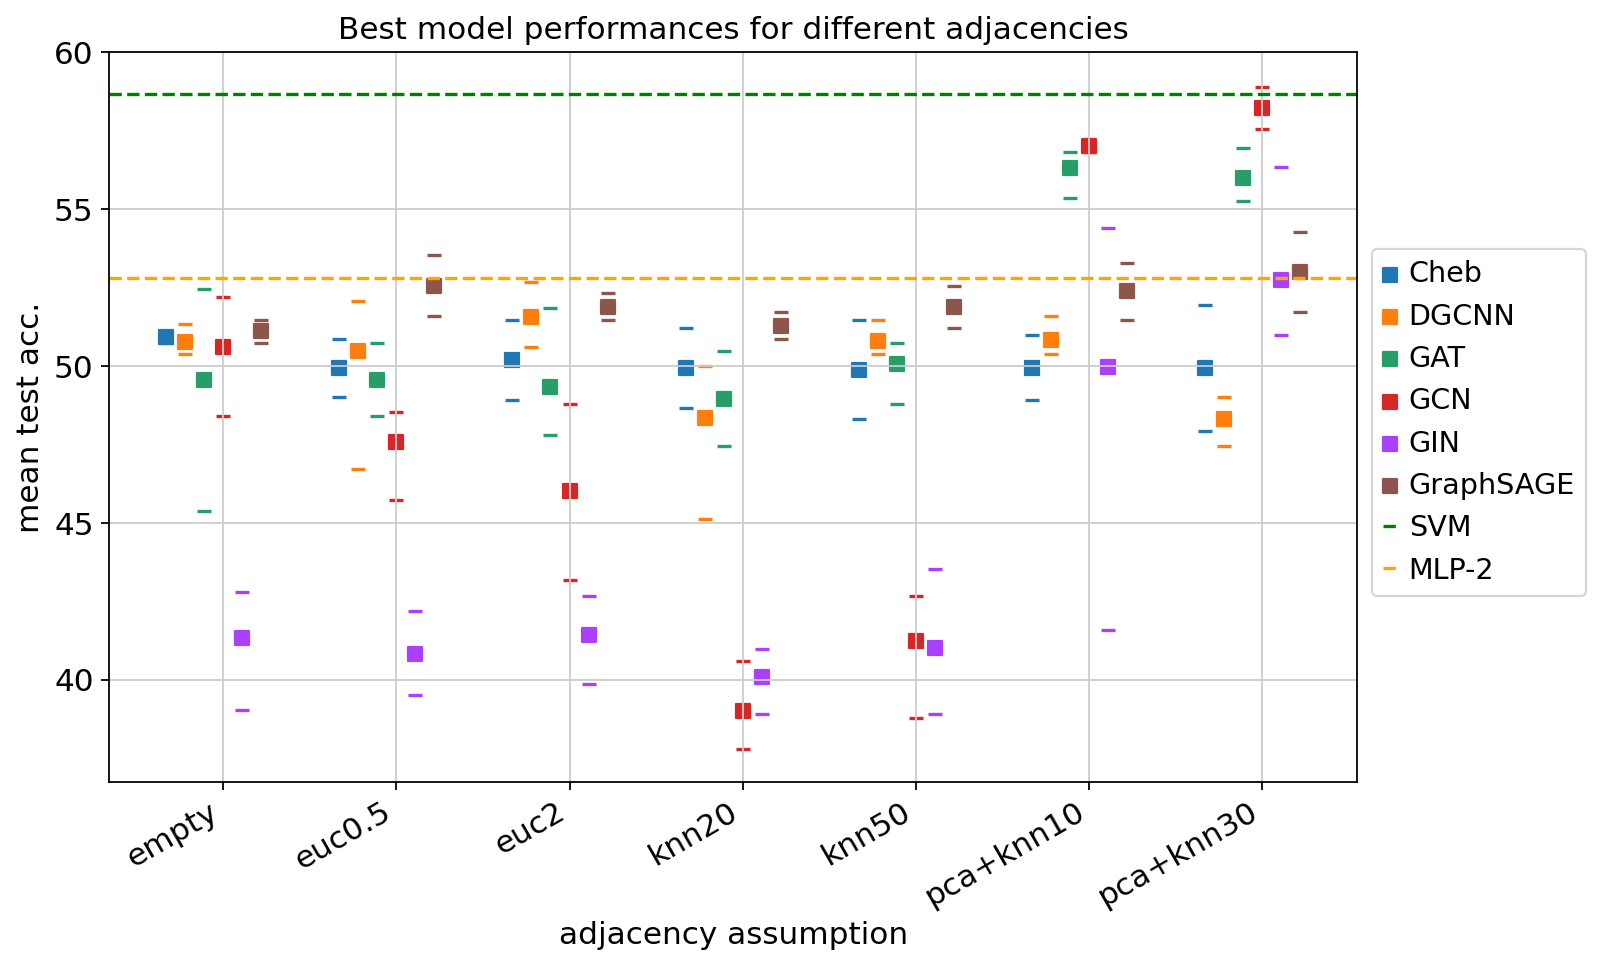

In [16]:
model_types = output_metrics.model_type.unique()
tmpdf = output_summary_bestparams.reset_index().sort_values('edge_index_type')
jitter = 0.11
fig, ax = plt.subplots(figsize=(10, 6))
xtl = None
for (i,m) in enumerate(model_types): 
    _df = tmpdf.loc[tmpdf.model_type == m]
    if xtl is None: 
        xtl = _df.edge_index_type.values
    else:
        assert (xtl == _df.edge_index_type.values).all()
    # _x = _df.edge_index_type
    _x = np.array(range(_df.edge_index_type.size)) + (i - len(model_types)/2)*jitter
    _p = ax.scatter(_x, _df.mean_test_acc, label=m, marker='s')
    ax.scatter(_x, _df.max_test_acc, marker='_', c=_p.get_facecolor())
    ax.scatter(_x, _df.min_test_acc, marker='_', c=_p.get_facecolor())
    # ax.errorbar(_df.edge_index_type, _df.mean_test_acc, yerr=(_df.max_test_acc - _df.min_test_acc)/2, marker='o', label=m)
ax.axhline(58.65853658536585, c='g', ls='--', label='SVM') 
ax.axhline(52.804874420166016, c='orange', ls='--', label='MLP-2') 
ybounds = ax.get_ybound()
ax.set_ybound((ybounds[0], (ybounds[1]//5 + 1)*5))
xtl = [plt.Text(float(i), i, t) for i,t in enumerate(xtl)]
ax.set_xticklabels([plt.Text(-1.0, 0, '-1')] + xtl + [plt.Text(-1.0, 0, str(len(xtl)))])
ax.legend(bbox_to_anchor=(1.0, 0.75))
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_ylabel('mean test acc.')
ax.set_xlabel('adjacency assumption')
ax.set_title('Best model performances for different adjacencies')
fig.savefig('./plots/ablation-adjacency-compare.png', bbox_inches="tight")

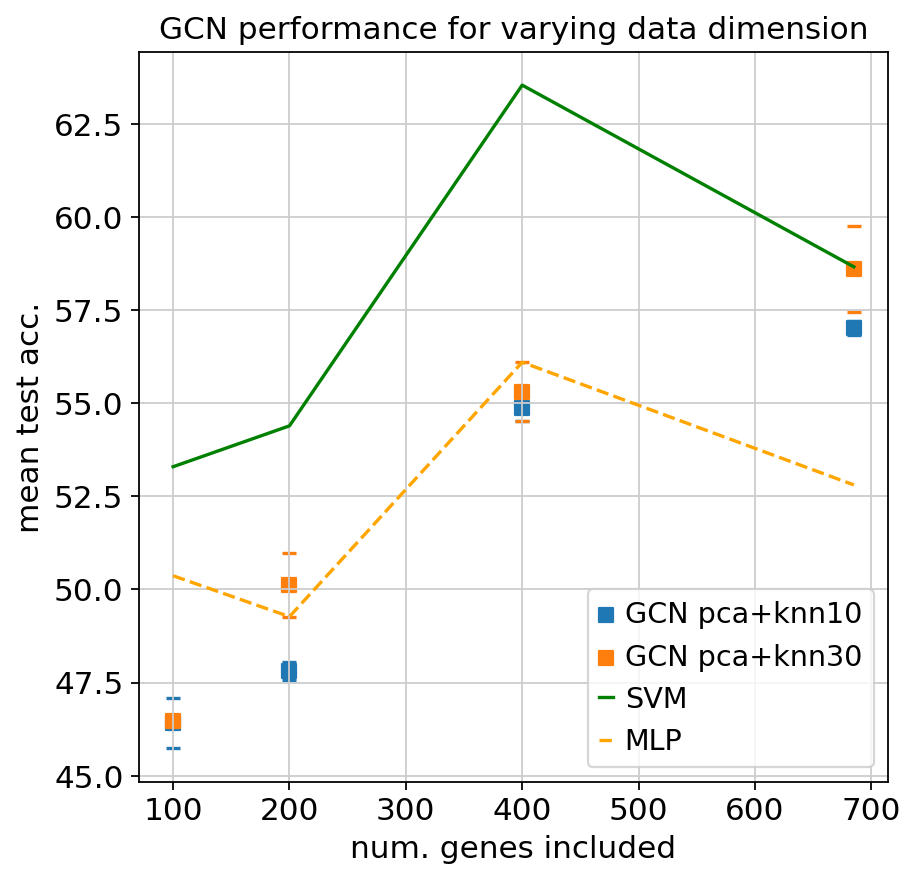

In [13]:
baselines_ngenes = [ 
    [53.29268292682927, 50.36585235595703, 48.1707305908203, 49.26829528808594],  # 100 genes
    [54.390243902439025, 49.26829528808594, 49.14634323120117, 49.14634323120117],  # 200 genes
    [63.53658536585366, 51.46341323852539, 56.09756088256836, 52.439022064208984],  # 400 genes
    [58.65853658536585, 52.07316970825195, 51.707313537597656, 52.804874420166016], 
]
baselines_ngenes = np.array(baselines_ngenes)
ngenes = np.array([100, 200, 400, 685])

if hasngenes: 
    es = ['pca+knn10', 'pca+knn30']
    _df = output_summary_bestparams.loc[('GCN', slice(None), es, slice(None))]
    gene_settings = output_configs.genes.unique()
    fig, ax = plt.subplots(figsize=(6, 6))
    for e in es: 
        _df2 = _df.loc[('GCN', slice(None), e, slice(None))]
        _x = [int(i[3].replace('genes', '')) for i in _df2.index]
        _p = ax.scatter(_x, _df2.mean_test_acc, label='GCN '+e, marker='s')
        ax.scatter(_x, _df2.max_test_acc, marker='_', c=_p.get_facecolor())
        ax.scatter(_x, _df2.min_test_acc, marker='_', c=_p.get_facecolor())
    ax.plot(ngenes, baselines_ngenes[:, 0], 'g-', label='SVM') 
    ax.plot(ngenes, baselines_ngenes[:, [1, 2, 3]].max(1), c='orange', linestyle='--', label='MLP') 
    # ax.legend(bbox_to_anchor=(1.0, 0.75))
    ax.legend()
    ax.set_ylabel('mean test acc.')
    ax.set_xlabel('num. genes included')
    ax.set_title('GCN performance for varying data dimension')
    fig.savefig('./plots/ablation-ngenes.png', bbox_inches="tight")
    fig.show()

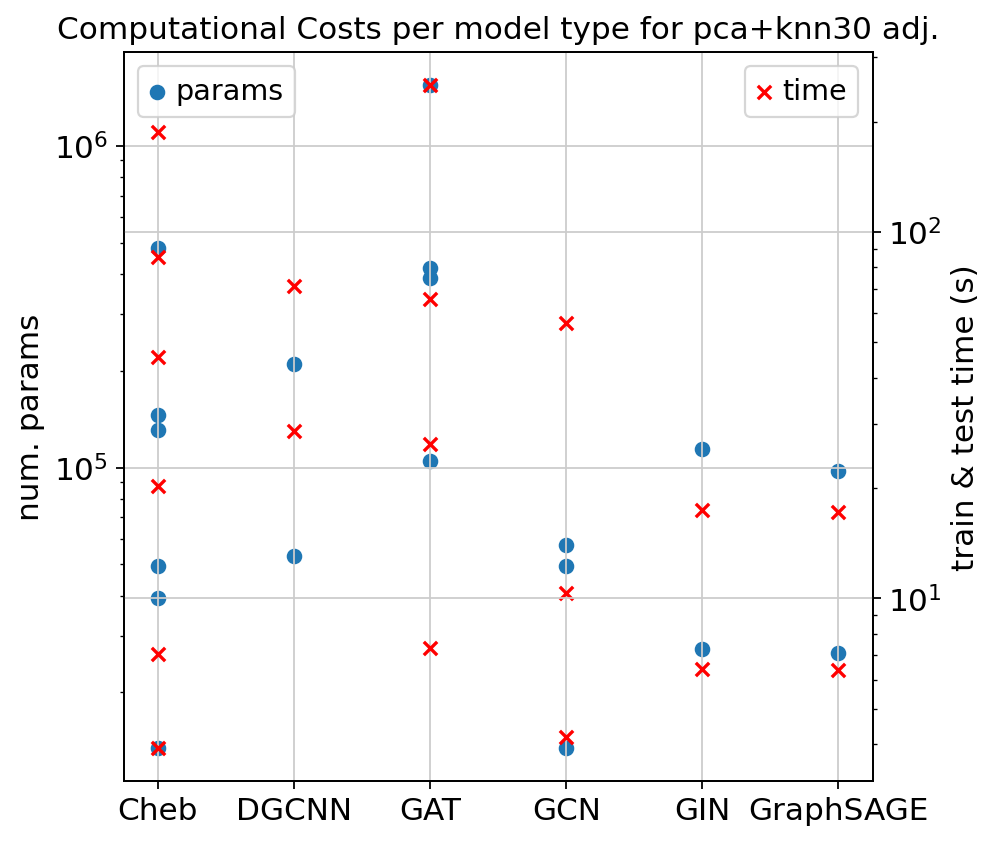

In [17]:
output_comp = output_summary.loc[(slice(None), slice(None), ['pca+knn30'])].reset_index().groupby(['model_type', 'model_params']).agg(nparams=('nparams', 'mean'), mean_time=('mean_time', 'mean')).reset_index()
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(output_comp.model_type, output_comp.nparams, label='params')
ax.set_yscale('log')
ax.set_ylabel('num. params')
ax2 = ax.twinx()
ax2.scatter(output_comp.model_type, output_comp.mean_time, c='r', marker='x', label='time')
ax2.set_yscale('log')
ax2.set_ylabel('train & test time (s)')

ax.legend(loc=2)
ax2.legend(loc=1)

ax.set_title('Computational Costs per model type for pca+knn30 adj.')
fig.savefig('./plots/ablation-computation.png', bbox_inches="tight")

look at adjacency densities

In [ ]:
import torch, torch_cluster
import numpy as np

import data 

adata = data.preprocess_paul15(data.get_paul15())
x = torch.tensor(adata.X)

adata = data.preprocess_leiden(adata, n_neighbors=30)
data.connectivities2edge_index(adata).shape
# torch_cluster.knn(x, x, 50).shape
# data.implied_edge_index(adata, threshold_quantile=q).shape

/home/hbl/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/usr/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50


/mnt/c/Users/han13/OneDrive/Documents/MPhil ACS/L45 Representation Learning on Graphs and Networks/project/code/data.py:132: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['paul15_clusters_ind'] = adata.obs.paul15_clusters.replace(cats.to_list(), range(len(cats)))


    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


torch.Size([2, 129840])

In [ ]:
torch_cluster.knn(x, x, 50).shape

torch.Size([2, 136500])

In [ ]:
data.implied_edge_index(adata, threshold_quantile=0.02).shape

Distance threshold 0.02 quantile: 17.21
Adjacency sparsity: 0.0211


torch.Size([2, 157100])

pca+knn (k=10) --> torch.Size([2, 41566])
knn (k=20) --> torch.Size([2, 54600])
euclidean (q=0.005) --> torch.Size([2, 51104])

pca+knn (k=30) --> torch.Size([2, 129840])
knn (k=50) --> torch.Size([2, 136500])
euclidean (q=0.005) --> torch.Size([2, 117614])